<a href="https://colab.research.google.com/github/rajarshisomvanshi/SolarCell/blob/main/SolarCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using 'jv_default_pce' as the target column.


<ipython-input-48-049721a40dad>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].mode()[0])
<ipython-input-48-049721a40dad>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].median())
<ipython-input-48-049721a40dad>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

MAE: 3.0491
MSE: 15.6055
RMSE: 3.9504
R² Score: 0.4361
Model and encoders saved


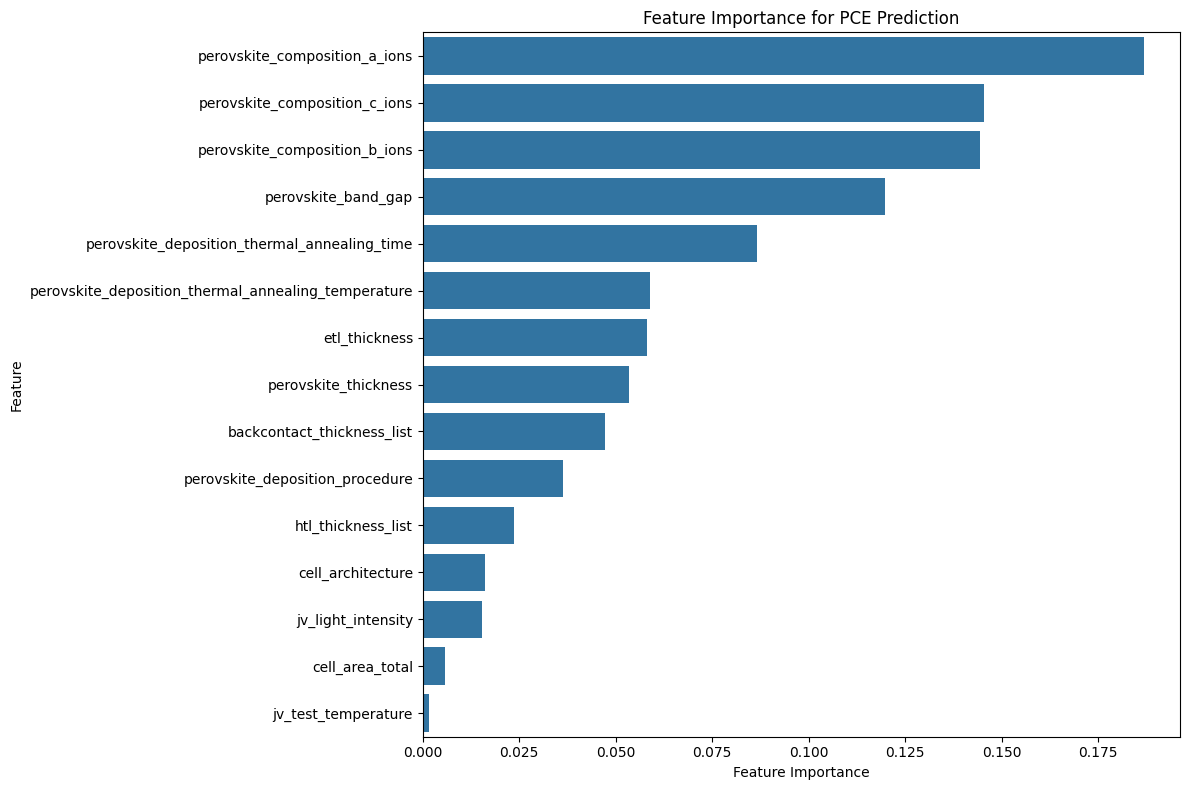

In [48]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/SolarCellDB.csv", low_memory=False)

# Standardize column names
df.columns = df.columns.str.strip().str.lower()

# Find the correct 'PCE' column dynamically
target_variable = None
for col in df.columns:
    if 'pce' in col.lower() and 'default' in col.lower():  # Focus on default PCE measurement
        target_variable = col
        break

if target_variable is None:
    raise KeyError("Could not find the 'PCE' column.")

print(f"Using '{target_variable}' as the target column.")

# Select relevant features based on domain knowledge
relevant_features = [
    # Perovskite composition
    'perovskite_composition_a_ions',
    'perovskite_composition_b_ions',
    'perovskite_composition_c_ions',
    'perovskite_band_gap',
    'perovskite_thickness',

    # Layer thicknesses
    'etl_thickness',
    'htl_thickness_list',
    'backcontact_thickness_list',

    # Deposition parameters
    'perovskite_deposition_procedure',
    'perovskite_deposition_thermal_annealing_temperature',
    'perovskite_deposition_thermal_annealing_time',

    # Measurement conditions
    'jv_light_intensity',
    'jv_test_temperature',

    # Cell architecture
    'cell_architecture',
    'cell_area_total'
]

# Filter dataset to only include relevant features and target
df = df[relevant_features + [target_variable]]

# Drop rows with missing target values
df = df.dropna(subset=[target_variable])

# Handle missing values in features
for col in relevant_features:
    if df[col].dtype == 'object':
        # For categorical columns, fill with mode
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        # For numerical columns, fill with median
        df[col] = df[col].fillna(df[col].median())

# Separate features and target
X = df[relevant_features]
y = df[target_variable]

# Encode categorical features while preserving names
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=15, n_jobs=-1)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Save the model
joblib.dump(model, "trained_model.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
print("Model and encoders saved")

# Feature Importance Plot with proper names
feature_importances = model.feature_importances_
feature_names = relevant_features  # Use original feature names
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_idx], y=np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance for PCE Prediction")
plt.tight_layout()
plt.show()